## Generating OpenFoam 6DoF Files

This Jupyter notebook will show you how to generate a simple 6 degree of freedom kinematic file for OpenFoam. The data file we will generate specifies the magnitude and direction of motion for a series of time points. 

It is a combination of a linear displacement vector and a rotation vector about the specified center of gravity (CofG) of the object, which is defined on the dynamicMeshDict file. 

This data file is later linearly interpolated by OpenFoam when running your CFD simulation, so your time points do not need to match exactly the timesteps you have set in OpenFoam. However, more time points will smooth your dynamics, increasing the accuracy of your simulation, specially if, as seen in the case below, you have a sinusoidal or other non-linear motion. 

The format of the data file we want to create for OpenFoam is shown below:

 4 //number of data points in the file
 //Position formatting is not important.  File is based on the character sequence only.
 //Vectors are not relative.  Each vector is total displacement and total rotation.
 
 (
 
 //(time_point ( (linear displacement vector)      (rotation vector roll-yaw-pitch) ) )
 
 //(seconds    ( (following unit system, usually meters)   (degrees) ) )
 
 (0            ( (0.25 0.50 1.0)                   (0.220 0.30 0.40) ) )    
 (0.25         ( (0.50 1.0 2.0)                    (0.60 0.60 0.60) ) )    
 (0.75         ( (0.75 5.0 1.0)                    (1.2 2.4 5.0) ) )    
 (10.0         ( (0.1 6.0 1.0)                   (5.0 3.0 5.5) ) )    
 )
 
Each time point first specifies the reference time, and the following bracket groups contains the motion, first linear and then angular displacement in their own lists.


We will begin by importing the libraries we need: Numpy, Pandas, MatPlotLib to visualize our output, OS to import paths, and IPython to clean up our display. 

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output

We will now add our parameters for the kinematics. In this case we are making an Eldredge function pure pitch movement, for 5 periods. The geometric angle of attack (our pitch angle) will be 45 degrees. It is a 2D motion, so most of our degrees of freedom are actually just going to be 0.  

In [21]:
numberofperiods = 5
alphaGeoAmp = 45

period = 3.801279221
resolution = 1000 #this is our time resolution, the number of data points our file will have

We are going to be saving this file as "eldredge.dat"

In [22]:
#outputfile
outputfilename = os.getcwd()
outputfilename += '/eldredge.dat'

We generate our time vector by using the numpy function linspace, with our set resolution

In [23]:
#time
time = np.linspace(0,period*numberofperiods,resolution)

And now it's just a question of creating our X,Y and Z vectors for our linear and rotational displacement. We will store them in a Pandas DataFrame (our motion matrix).

The Eldredge function is defined as:

In [24]:
def EldRampUp(amp,K,a,t):
    sm = np.pi*np.pi*K/(2*(amp)*(1 - a))
    t1 = 1.
    t2 = t1 + ((amp)/(2*K))
    return ((K/sm)*np.log(np.cosh(sm*(t - t1))/np.cosh(sm*(t - t2))))+(amp/2)

In [25]:
#linear displacement
linearDisplacement = pd.DataFrame(data=time,columns={'Time'})
linearDisplacement['X'] = 0
linearDisplacement['Y'] = 0
linearDisplacement['Z'] = 0

#rotational displacement
rotationalDisplacement = pd.DataFrame(data=time,columns={'Time'})
rotationalDisplacement['phi'] = 0
rotationalDisplacement['psi'] = 0
rotationalDisplacement['theta'] = -EldRampUp(45*np.pi/180,0.4,0.8,time)

In [26]:
type(EldRampUp(45*np.pi/180,0.4,0.8,time))

numpy.ndarray

In [27]:
linearDisplacement

,Time,X,Y,Z
0,0.000000,0,0,0
1,0.019025,0,0,0
2,0.038051,0,0,0
3,0.057076,0,0,0
4,0.076102,0,0,0
...,...,...,...,...
995,18.930294,0,0,0
996,18.949320,0,0,0
997,18.968345,0,0,0
998,18.987371,0,0,0


In [28]:
rotationalDisplacement

,Time,phi,psi,theta
0,0.000000,0,0,-3.870237e-13
1,0.019025,0,0,-6.243339e-13
2,0.038051,0,0,-1.007305e-12
3,0.057076,0,0,-1.624867e-12
4,0.076102,0,0,-2.621015e-12
...,...,...,...,...
995,18.930294,0,0,-7.853982e-01
996,18.949320,0,0,-7.853982e-01
997,18.968345,0,0,-7.853982e-01
998,18.987371,0,0,-7.853982e-01


Finally we can save our motion file, adding our different brackets and required formatting as per OpenFoam's requirements. We will use the f.write file writer, and build each line with a for loop. 

In [35]:
#saving motion file

f= open(outputfilename,"w+")

f.write(str(resolution) + '\n(\n')

i = 0

for i in range(0, len(linearDisplacement)):
    
    line = '('
    line += str(linearDisplacement['Time'].iloc[i])
    line += '(('
    line += str(linearDisplacement['X'].iloc[i])
    line += ' '
    line += str(linearDisplacement['Y'].iloc[i])
    line += ' '
    line += str(linearDisplacement['Z'].iloc[i])
    line += ')('
    line += str(rotationalDisplacement['phi'].iloc[i])
    line += ' '
    line += str(rotationalDisplacement['psi'].iloc[i])
    line += ' '
    line += str(rotationalDisplacement['theta'].iloc[i])
    line += ')))\n'
    
    f.write(line)
    
    i = i + 1
    
    if i%1000==0: #this is a tiny add-on I like to use as a test and map progress
        print('Completing save ',round(i/resolution*100,2), '%')
        clear_output(wait=True)
            
f.write(')')


1

We will now plot our linear displacement to double check our motion: 

Text(0.5, 1.0, 'Linear Displacement against non-dimensional time')

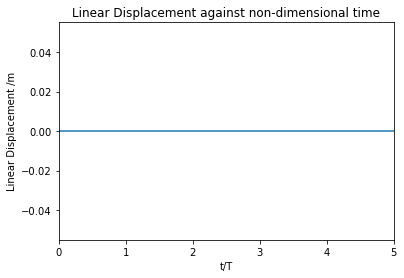

In [30]:
plt.plot(linearDisplacement['Time']/period, linearDisplacement['Y'])
plt.xlim(0,numberofperiods)
plt.ylabel("Linear Displacement /m")
plt.xlabel("t/T")
plt.title("Linear Displacement against non-dimensional time")

And now our rotational displacement:

Text(0.5, 1.0, 'Angular displacement against time')

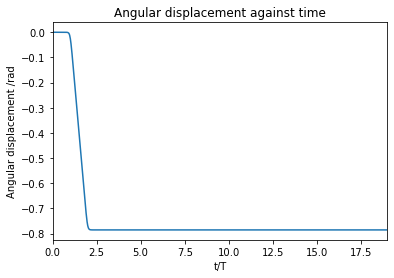

In [31]:
plt.plot(rotationalDisplacement['Time'],rotationalDisplacement['theta'])
plt.xlim(0,numberofperiods*period)
plt.ylabel("Angular displacement /rad")
plt.xlabel("t/T")
plt.title("Angular displacement against time")